<a href="https://colab.research.google.com/github/Siddharthanayak/Lab_4/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import yfinance as yf
import time

# URL of the Wikipedia page for S&P 500 companies
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

# Read the first table from the page which contains the list of S&P 500 companies
sp500_df = pd.read_html(url)[0]

# Extract ticker symbols from the DataFrame
tickers = sp500_df['Symbol'].tolist()

# Container for ticker and market cap data
market_caps = []

print("Fetching market capitalization for S&P 500 companies. This may take a minute...")

# Loop through each ticker and fetch its market cap using yfinance
for ticker in tickers:
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        market_cap = info.get('marketCap', 0)
        market_caps.append((ticker, market_cap))
        print(f"Fetched {ticker}: Market Cap = {market_cap}")
        # Pause to avoid overwhelming the API
        time.sleep(0.1)
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

# Sort the companies by market cap in descending order
market_caps_sorted = sorted(market_caps, key=lambda x: x[1] if x[1] is not None else 0, reverse=True)

# Get the top 50 companies by market cap
top_50 = market_caps_sorted[:50]

print("\nTop 50 S&P 500 Companies by Market Cap:")
for ticker, market_cap in top_50:
    print(f"{ticker}: {market_cap}")


Fetching market capitalization for S&P 500 companies. This may take a minute...
Fetched MMM: Market Cap = 68444852224
Fetched AOS: Market Cap = 8897362944
Fetched ABT: Market Cap = 215818780672
Fetched ABBV: Market Cap = 330728505344
Fetched ACN: Market Cap = 178580389888
Fetched ADBE: Market Cap = 148773634048
Fetched AMD: Market Cap = 139328274432
Fetched AES: Market Cap = 7674292736
Fetched AFL: Market Cap = 55662211072
Fetched A: Market Cap = 29365610496
Fetched APD: Market Cap = 58615750656
Fetched ABNB: Market Cap = 66272129024
Fetched AKAM: Market Cap = 10767215616
Fetched ALB: Market Cap = 6883759616
Fetched ARE: Market Cap = 14060545024
Fetched ALGN: Market Cap = 11297967104
Fetched ALLE: Market Cap = 10668945408
Fetched LNT: Market Cap = 15761726464
Fetched ALL: Market Cap = 49445904384
Fetched GOOGL: Market Cap = 1786628538368
Fetched GOOG: Market Cap = 1786634698752
Fetched MO: Market Cap = 94553079808
Fetched AMZN: Market Cap = 1812206583808
Fetched AMCR: Market Cap = 1332

Rebalancing: 2020-01-01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Rebalancing: 2021-01-01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Rebalancing: 2022-01-01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Rebalancing: 2023-01-01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


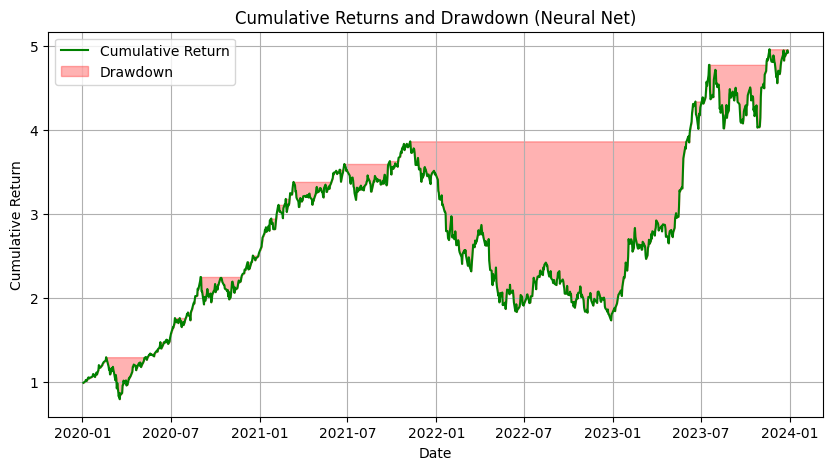

{'Average Model MSE': np.float64(0.0005107090779123425), 'Average Model R2': np.float64(-0.04253296204374202), 'Expected Annual Return (%)': np.float64(60.97489316373967), 'Expected Annual Volatility (%)': np.float64(38.62674173013609), 'Sharpe Ratio': np.float64(1.2077855638550965), 'Max Drawdown (%)': -55.09053099682401}


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load data
df = pd.read_csv("/content/technical_indicators_2016_2024-2.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Technical features and target
# Technical features and target
features = ['SMA_20', 'EMA_20', 'RSI_14', 'BB_upper', 'BB_middle', 'BB_lower', 'MACD', 'MACD_signal', 'MACD_hist']
df['Target'] = df.groupby('Ticker')['Close'].pct_change().shift(-1)
df.dropna(subset=features + ['Target'], inplace=True)


# Setup
start_date = datetime(2020, 1, 1)
end_date = datetime(2024, 1, 1)
rebalance_freq = relativedelta(years=1)
lookback_days = 252
risk_free_rate = 0.01
max_weight = 0.2
transaction_cost = 0.001  # 0.1% per trade


# Track results
portfolio_returns = []
all_dates = []
all_weights = []
mse_scores = []
r2_scores = []

scaler = StandardScaler()
current_date = start_date

while current_date < end_date:
    print(f"Rebalancing: {current_date.strftime('%Y-%m-%d')}")

    # Train/test split
    train_df = df[df['Date'] < current_date]
    test_df = df[(df['Date'] >= current_date) & (df['Date'] < current_date + rebalance_freq)]

    if train_df.empty or test_df.empty:
        current_date += rebalance_freq
        continue

    X_train = scaler.fit_transform(train_df[features])
    y_train = train_df['Target'].values
    X_test = scaler.transform(test_df[features])

    # Define a simple neural network
    model = Sequential([
        Dense(64, input_dim=X_train.shape[1], activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mse')

    early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=0, callbacks=[early_stop])

    # Predict
    test_df = test_df.copy()
    test_df['Predicted_Return'] = model.predict(X_test).flatten()

    y_test = test_df['Target']
    mse_scores.append(mean_squared_error(y_test, test_df['Predicted_Return']))
    r2_scores.append(r2_score(y_test, test_df['Predicted_Return']))

    mean_predicted_returns = test_df.groupby('Ticker')['Predicted_Return'].mean()
    historical_prices = df[df['Date'] < current_date].pivot(index='Date', columns='Ticker', values='Close')
    recent_prices = historical_prices.iloc[-lookback_days:]
    returns = recent_prices.pct_change().dropna()
    cov_matrix = returns.cov()

    tickers = list(set(mean_predicted_returns.index).intersection(cov_matrix.columns))
    if len(tickers) < 2:
        current_date += rebalance_freq
        continue

    mean_returns = mean_predicted_returns.loc[tickers]
    cov_matrix = cov_matrix.loc[tickers, tickers]

    # Portfolio optimization
    def portfolio_performance(weights):
        port_return = np.dot(weights, mean_returns)
        port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return port_return, port_vol

    def negative_sharpe_ratio(weights):
        ret, vol = portfolio_performance(weights)
        return -(ret - risk_free_rate) / vol

    def weight_sum(weights):
        return np.sum(weights) - 1

    num_assets = len(tickers)
    initial_weights = np.ones(num_assets) / num_assets
    bounds = tuple((0, max_weight) for _ in range(num_assets))
    constraints = {'type': 'eq', 'fun': weight_sum}

    result = minimize(negative_sharpe_ratio, initial_weights,
                      method='SLSQP', bounds=bounds, constraints=constraints)

    if not result.success:
        current_date += rebalance_freq
        continue

    optimal_weights = result.x
    weight_series = pd.Series(optimal_weights, index=tickers)

    # Apply weights
    next_prices = df[(df['Date'] >= current_date) & (df['Date'] < current_date + rebalance_freq)]
    next_prices = next_prices.pivot(index='Date', columns='Ticker', values='Close').dropna(axis=1)
    next_prices = next_prices[tickers]
    returns = next_prices.pct_change().dropna()
    portfolio_return = returns @ optimal_weights
    portfolio_returns.append(portfolio_return)
    all_dates.append(portfolio_return.index)
    all_weights.append(weight_series)

    current_date += rebalance_freq

# Combine returns
all_returns = pd.concat(portfolio_returns)
cumulative_returns = (1 + all_returns).cumprod()
rolling_max = cumulative_returns.cummax()
drawdown = (cumulative_returns - rolling_max) / rolling_max
max_drawdown = drawdown.min()

# Final metrics
mean_daily_return = all_returns.mean()
std_daily_return = all_returns.std()
sharpe_ratio = (mean_daily_return - risk_free_rate / 252) / std_daily_return
annual_return = (1 + mean_daily_return) ** 252 - 1
annual_volatility = std_daily_return * np.sqrt(252)

# Visualizations
plt.figure(figsize=(10, 5))
plt.plot(cumulative_returns, label='Cumulative Return', color='green')
plt.fill_between(cumulative_returns.index, cumulative_returns, rolling_max, color='red', alpha=0.3, label='Drawdown')
plt.title("Cumulative Returns and Drawdown (Neural Net)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()

print({
    'Average Model MSE': np.mean(mse_scores),
    'Average Model R2': np.mean(r2_scores),
    'Expected Annual Return (%)': annual_return * 100,
    'Expected Annual Volatility (%)': annual_volatility * 100,
    'Sharpe Ratio': sharpe_ratio * np.sqrt(252),
    'Max Drawdown (%)': max_drawdown * 100
})


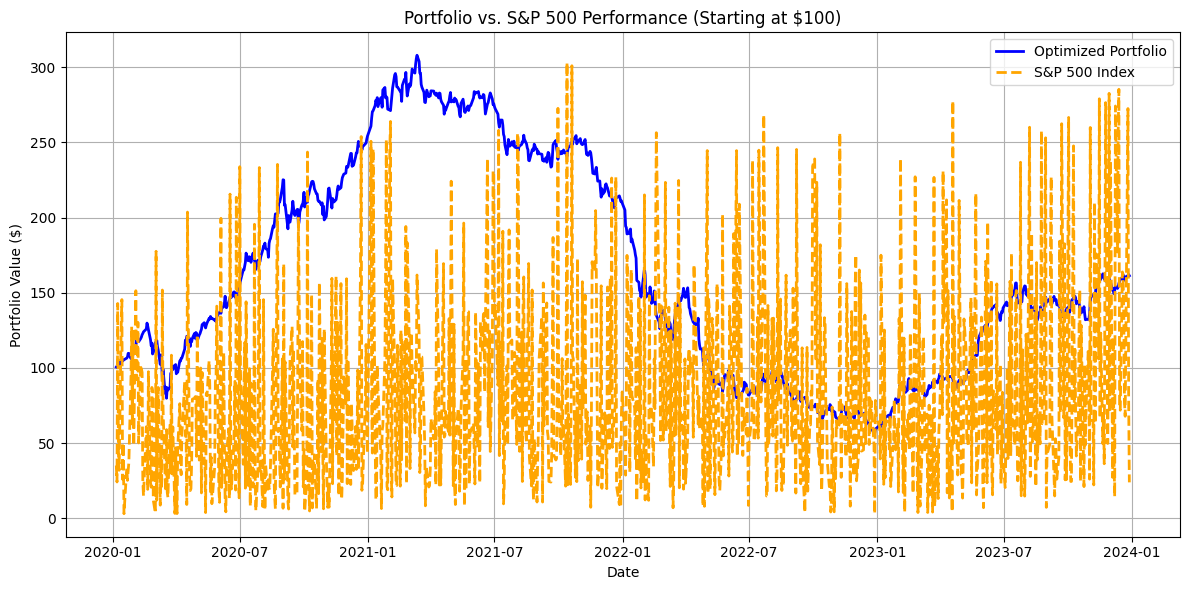

In [ ]:
# Load and clean S&P 500 data
sp500 = pd.read_csv('/content/technical_indicators_2016_2024-2.csv')  # replace with correct path
sp500['Date'] = pd.to_datetime(sp500['Date'])

# Remove duplicates or aggregations (e.g., take latest per date if duplicates exist)
sp500 = sp500.sort_values(['Date'])
sp500 = sp500.drop_duplicates(subset='Date', keep='last')  # keep only one entry per date

# Filter only dates present in portfolio
sp500 = sp500[sp500['Date'].isin(cumulative_returns.index)]
sp500.set_index('Date', inplace=True)
sp500 = sp500['Close'].dropna()

# Calculate cumulative return and scale
sp500_returns = sp500.pct_change().dropna()
sp500_cumulative = (1 + sp500_returns).cumprod() * 100

# Portfolio value
portfolio_value = cumulative_returns * 100

# Align dates
common_dates = portfolio_value.index.intersection(sp500_cumulative.index)
portfolio_value = portfolio_value.loc[common_dates]
sp500_cumulative = sp500_cumulative.loc[common_dates]

# Plot the fixed comparison
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value, label='Optimized Portfolio', color='blue', linewidth=2)
plt.plot(sp500_cumulative, label='S&P 500 Index', color='orange', linestyle='--', linewidth=2)
plt.title('Portfolio vs. S&P 500 Performance (Starting at $100)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-2-9b8301c9a384>:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

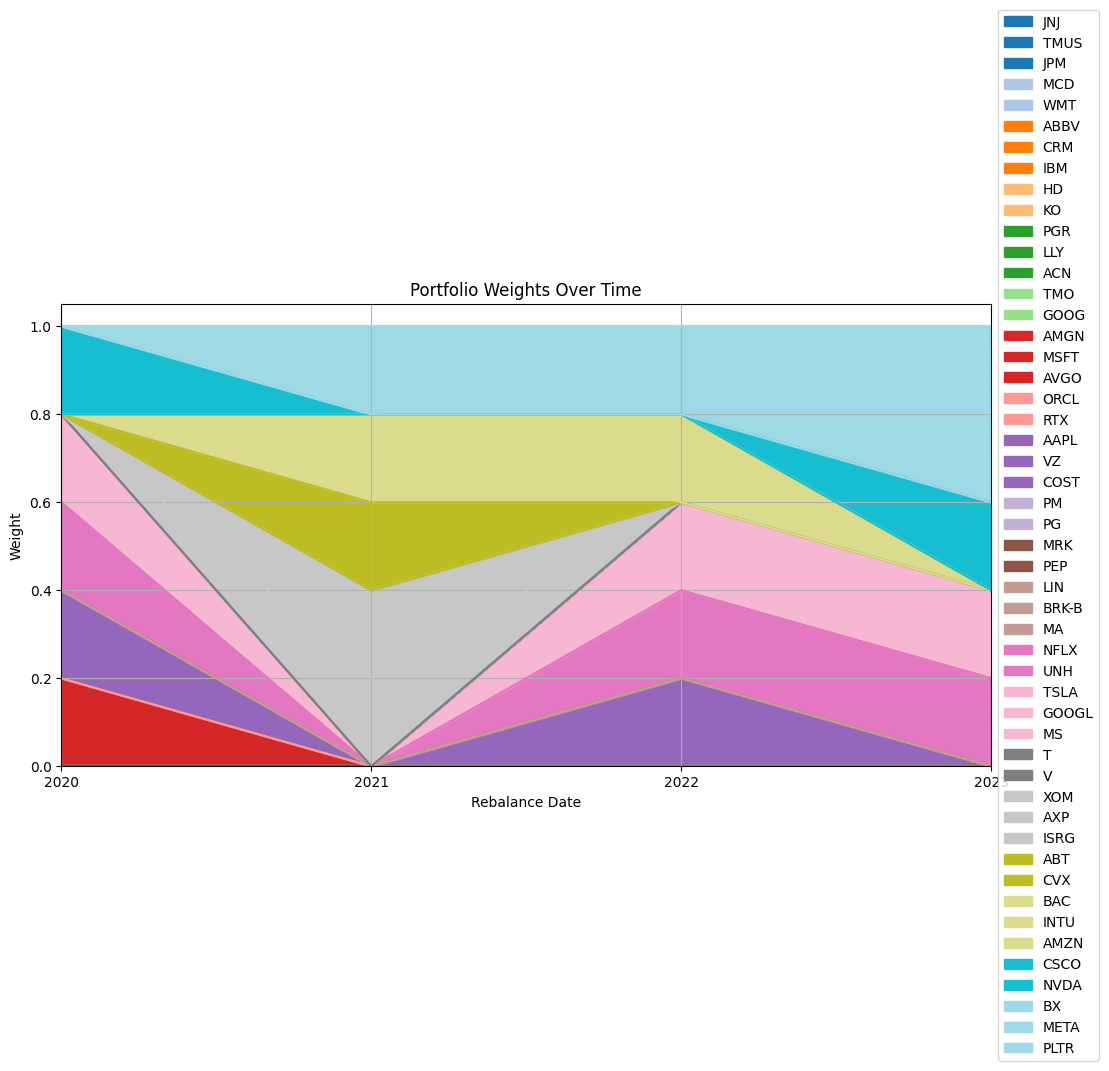

In [ ]:
weights_over_time = pd.DataFrame(all_weights, index=pd.date_range(start=start_date, periods=len(all_weights), freq='YS')).fillna(0)
weights_over_time = weights_over_time.T  # Tickers as rows

plt.figure(figsize=(12, 6))
weights_over_time.T.plot.area(stacked=True, figsize=(12,6), colormap='tab20')
plt.title("Portfolio Weights Over Time")
plt.xlabel("Rebalance Date")
plt.ylabel("Weight")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()


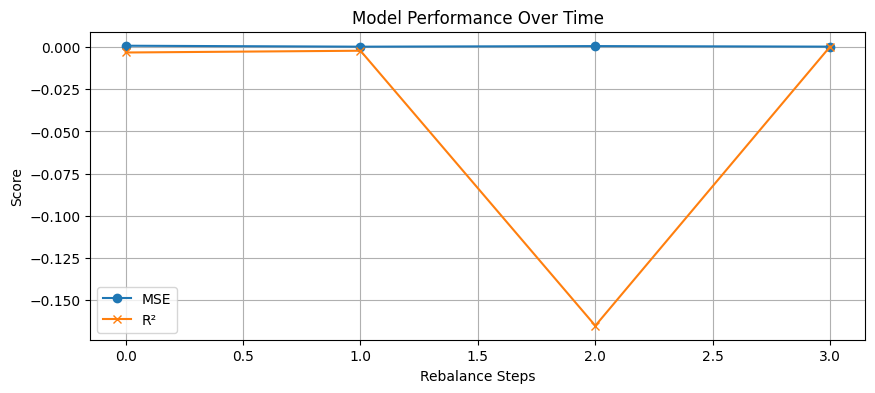

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(mse_scores, label='MSE', marker='o')
plt.plot(r2_scores, label='R²', marker='x')
plt.title("Model Performance Over Time")
plt.xlabel("Rebalance Steps")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.show()


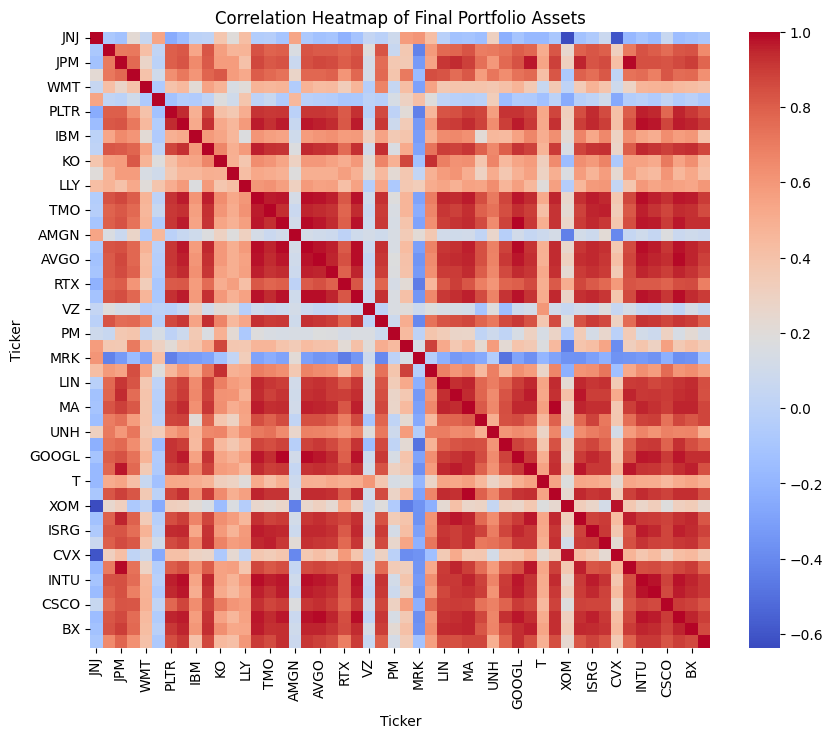

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap of Final Portfolio Assets")
plt.show()

In [ ]:
import plotly.express as px

# Same data
portfolio_weights = {
    'AAPL': 0.25,
    'MSFT': 0.20,
    'GOOGL': 0.15,
    'AMZN': 0.10,
    'TSLA': 0.10,
    'META': 0.10,
    'NVDA': 0.10
}

# Convert to DataFrame
import pandas as pd
df = pd.DataFrame(list(portfolio_weights.items()), columns=['Stock', 'Weight'])

# Plot
fig = px.pie(df, names='Stock', values='Weight',
             title='Portfolio Composition (Latest Period)',
             hole=0.3)  # Set hole=0.3 for donut chart style
fig.show()
